# UMAP Experiment

In [1]:
import os

# os.environ["NUMBA_NUM_THREADS"] = "32"

import datasets

import warnings
warnings.filterwarnings("ignore")


from umap import UMAP as UMAP_LEARN
from cuml.manifold import UMAP as UMAP_CUML
# from gpumap import GPUMAP as UMAP_GPUMAP

In [2]:
import matplotlib.pyplot as plt

In [3]:
def draw_chart(model, X, y, dataset, model_name, classes=None):
    
    embedding = model.fit_transform(X, y)
    
    fig, ax = plt.subplots(1, figsize=(14, 10))
    plt.scatter(embedding[:,1], embedding[:,0], s=0.3, c=y, cmap='Spectral', alpha=1.0)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    cbar.set_ticks(np.arange(10))
    if classes is not None:
        cbar.set_ticklabels(classes)
    plt.title("%s Embedded via %s" % (dataset, model_name));

In [4]:
from cuml.metrics import trustworthiness
# from sklearn.manifold.t_sne import trustworthiness
from sklearn.model_selection import train_test_split
import time
import numpy as np

batchSize = 1024


def _run_build_and_train_once(model_class, X, y=None, kwargs={}, verbose=False, eval_trust=True):
    
    results = {}
    
#     kwargs["n_epochs"] = 500

    # Unsupervised
    if verbose:
        print("Unsupervised")
    model = model_class(**kwargs)

    try:
        start = time.time()
        embeddings = model.fit_transform(X)
        end = time.time() - start

        if verbose:
            print("Time: "+ str(end))
    
        n_neighbors = model.n_neighbors
        del model

        if eval_trust:
            if verbose:
                print("Done. Evaluating trustworthiness")
            trust = trustworthiness(X, embeddings, n_neighbors=n_neighbors, batch_size=batchSize)
        else:
            trust = None
        
        if verbose:
            print(str(trust))
        results["unsupervised"] = {"time": end, "trust": trust}
    except:
        import traceback
        traceback.print_exc()
    
    # Supervised

    if y is not None:
        if verbose:
            print("Supervised")
        kwargs["target_metric"] = "categorical"
        model = model_class(**kwargs)

        try:
            start = time.time()
            embeddings = model.fit_transform(X, y)
            end = time.time() - start


            n_neighbors = model.n_neighbors
            del model

            if eval_trust:
                if verbose:
                    print("Done. Evaluating trustworthiness")
                trust = trustworthiness(X, embeddings, n_neighbors=n_neighbors, batch_size=batchSize)
            else:
                trust = None

            if verbose:
                print(str(trust))
                print("Time: "+ str(end))

            results["supervised"] = {"time": end, "trust": trust}
        except:
            import traceback
            traceback.print_exc()
    
    # Transform
    

    if verbose:
        print("Transform")
    model = model_class(**kwargs)

    try:

        start = time.time()
        model.fit(X, y)
        embeddings = model.transform(X)
        end = time.time() - start

        n_neighbors = model.n_neighbors
        del model

        if eval_trust:
            if verbose:
                print("Done. Evaluating trustworthiness")
            trust = trustworthiness(X, embeddings, n_neighbors=n_neighbors, batch_size=batchSize)
        else:
            trust = None

        if verbose:
            print(str(trust))
            print("Time: "+ str(end))
        results["xform"] = {"time": end, "trust": trust}        
    except:
        import traceback
        traceback.print_exc()
        
    return results

def build_and_train(model_class, X, y=None, kwargs={}, n_trials=4, verbose=False, eval_trust=True):
    
    results = []
    
    for trial in range(n_trials):
        results.append(_run_build_and_train_once(model_class, X, y, kwargs, verbose, eval_trust))
        
    return results

In [5]:
def store_results(results, filename):
    import pickle
    with open(filename, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
final_results = {}

## Pen Digits Dataset

In [21]:
from sklearn.datasets import load_digits

data = load_digits()

X = data.data
y = data.target

In [22]:
results_digits = {}

In [23]:
results_digits["umapcuml"] = build_and_train(UMAP_CUML, X, y, {})

In [24]:
results_digits["umaplearn"] = build_and_train(UMAP_LEARN, X, y, {})

In [10]:
results_digits["umapgpumap"] = build_and_train(UMAP_GPUMAP, X, y, {})

Unsupervised


/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/gpumap/gpumap_.py:798: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_epochs_per_sample" failed type inference due to: Untyped global name 'make_epochs_per_sample_gpu': cannot determine Numba type of <class 'function'>

File "../../software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/gpumap/gpumap_.py", line 816:
def make_epochs_per_sample(weights, n_epochs, use_gpu):
    <source elided>
    if use_gpu:
        fun = make_epochs_per_sample_gpu
        ^

  @numba.jit()
/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "make_epochs_per_sample" was compiled in object mode without forceobj=True.

File "../../software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/gpumap/gpumap_.py", line 799:
@numba.jit()
def make_epochs_per_sample(weights, n_epochs, 

Time: 48.58267402648926
Done. Evaluating trustworthiness


/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


0.9500652367081384
Supervised


/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/gpumap/gpumap_.py:729: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "categorical_simplicial_set_intersection" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at /share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/gpumap/gpumap_.py (759)

File "../../software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/gpumap/gpumap_.py", line 759:
def categorical_simplicial_set_intersection(
    <source elided>
    """
    simplicial_set = simplicial_set.tocoo()
    ^

  @numba.jit()
/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "categorical_simplicial_set_intersection" was compiled in object mode without forceobj=True.

File "../../software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/gpumap/gpumap_.p

Transform


Traceback (most recent call last):
  File "<ipython-input-6-4dd172dc1caa>", line 74, in build_and_train
    model.fit(X, y)
  File "/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/gpumap/gpumap_.py", line 1740, in fit
    self.use_gpu,
  File "/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/gpumap/gpumap_.py", line 561, in fuzzy_simplicial_set
    knn_dists, angular, set_op_mix_ratio, local_connectivity, verbose)
  File "/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/gpumap/gpumap_.py", line 575, in fuzzy_simplicial_set_gpu
    knn_indices = cp.asarray(knn_indices)
  File "/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/cupy/creation/from_data.py", line 68, in asarray
    return core.array(a, dtype, False, order)
  File "cupy/core/core.pyx", line 1785, in cupy.core.core.array
  File "cupy/core/core.pyx", line 1862, in cupy.core.core.array
  File "cupy/core/core.pyx", line 1937, 

In [9]:
final_results["digits"] = results_digits

{'umapcuml': {'unsupervised': {'time': 0.6756539344787598, 'trust': 0.988478124528814}, 'supervised': {'time': 0.1429595947265625, 'trust': 0.9879212441630452}, 'xform': {'time': 0.2402510643005371, 'trust': 0.982670081268271}}, 'umaplearn': {'unsupervised': {'time': 7.788630723953247, 'trust': 0.9878795027078618}, 'supervised': {'time': 5.32893967628479, 'trust': 0.9873353789992382}, 'xform': {'time': 5.482668876647949, 'trust': 0.9874756813152824}}}


## Fashion MNIST Dataset

In [25]:
# https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels


In [26]:
train, train_labels = load_mnist('data/fashion', kind='train')
test, test_labels = load_mnist('data/fashion', kind='t10k')
X = (np.array(np.vstack([train, test]), dtype=np.float64) [:50000]/ 255.0).astype(np.float32)
y = np.array(np.hstack([train_labels, test_labels]))[:50000].astype(np.float32)

In [27]:
results_fashion = {}

In [28]:
results_fashion["umapcuml"] = build_and_train(UMAP_CUML, X, y, {})

In [29]:
results_fashion["umaplearn"] = build_and_train(UMAP_LEARN, X, y, {})

In [ ]:
results_fashion["umapgpumap"] = build_and_train(UMAP_GPUMAP, X, y, {"n_neighbors": 5, "min_dist": 0.01})

Unsupervised


In [9]:
final_results["fashion_mnist"] = results_fashion

{'umapgpumap': {'unsupervised': {'time': 9.56964659690857,
   'trust': 0.9791205402464395}}}

In [5]:
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

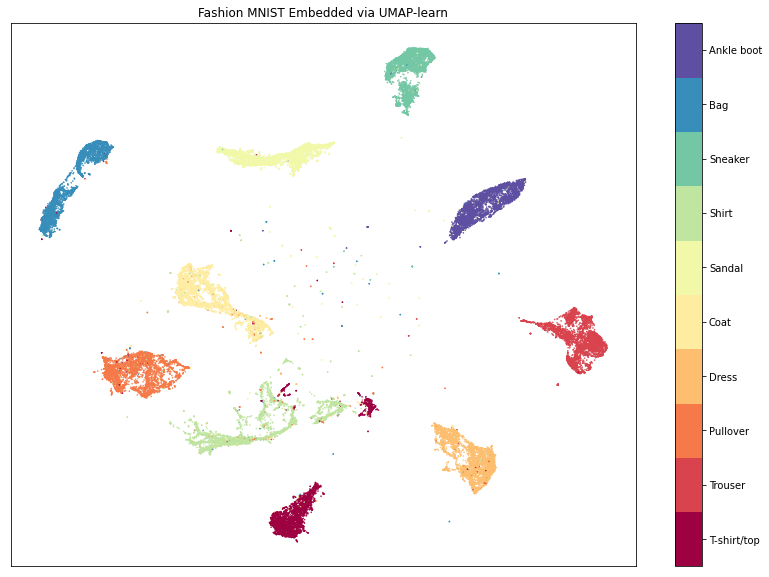

In [168]:
draw_chart(UMAP_LEARN(n_neighbors=10, min_dist=0.01), X, y, "Fashion MNIST", "UMAP-learn", classes)

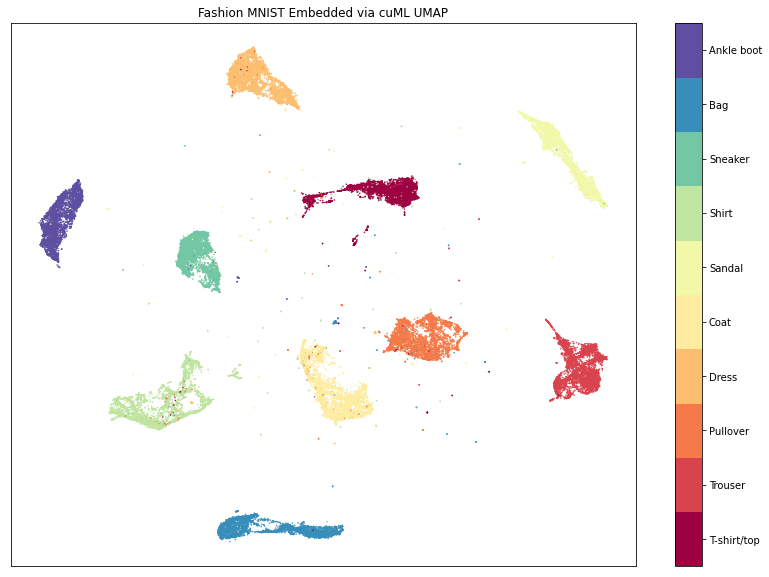

In [167]:
draw_chart(UMAP_CUML(n_neighbors=10, min_dist=0.01), X, y, "Fashion MNIST", "cuML UMAP", classes)

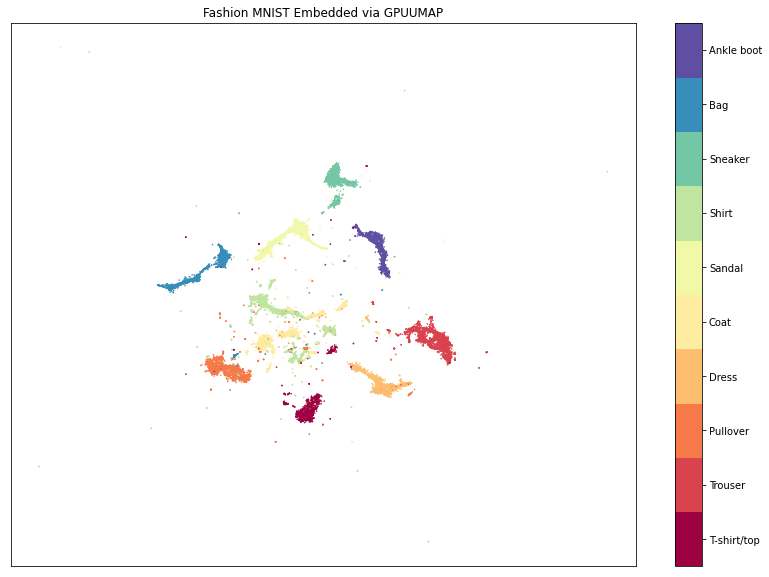

In [10]:
draw_chart(UMAP_GPUMAP(n_neighbors=10, min_dist=0.01), X, y, "Fashion MNIST", "GPUUMAP", classes)

### CIFAR-100

In [5]:
import pickle
import os
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar100(path="data/cifar100/cifar-100-python"):
    train = unpickle(os.path.join(path, "train"))
    test = unpickle(os.path.join(path, "test"))
    
    return train, test

In [6]:
train, test = load_cifar100()

train, train_labels = (train[b"data"], train[b"fine_labels"])
test, test_labels = (test[b"data"], test[b"fine_labels"])

In [7]:
X = (np.array(np.vstack([train, test]), dtype=np.float64) [:60000]/ 255.0).astype(np.float32)
y = np.array(np.hstack([train_labels, test_labels]))[:60000].astype(np.float32)

In [8]:
results_cifar100 = {}

In [12]:
results_cifar100["umaplearn"] = build_and_train(UMAP_LEARN, X, y, {})

Unsupervised
Time: 97.46222305297852
Done. Evaluating trustworthiness


/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


0.8445618403165658
Supervised
Done. Evaluating trustworthiness


/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


0.8451766331723457
Transform
Done. Evaluating trustworthiness


/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


0.8472258750669238


In [14]:
results_cifar100["umapcuml"] = build_and_train(UMAP_CUML, X, y, {})

Unsupervised
Time: 1.2385873794555664
Done. Evaluating trustworthiness


/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


0.8339496451417487
Supervised


/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/cuml-0.14.0a0+1395.gb1d7c16-py3.7-linux-x86_64.egg/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "
/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


Done. Evaluating trustworthiness
0.8384627042588548
Transform
Done. Evaluating trustworthiness


/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


0.8299595964564194


In [11]:
results_cifar100["umapcuml"]

{'unsupervised': {'time': 1.147784948348999, 'trust': 0.8262610769683935},
 'supervised': {'time': 1.4151732921600342, 'trust': 0.8376757407747044},
 'xform': {'time': 2.5040030479431152, 'trust': 0.8302579843199152}}

In [9]:
results_cifar100["umapgpumap"] = build_and_train(UMAP_GPUMAP, X, y, {"n_neighbors":50})

Unsupervised


/share/conda/cuml_13_2/lib/python3.7/site-packages/gpumap/gpumap_.py:798: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_epochs_per_sample" failed type inference due to: Untyped global name 'make_epochs_per_sample_gpu': cannot determine Numba type of <class 'function'>

File "../../conda/cuml_13_2/lib/python3.7/site-packages/gpumap/gpumap_.py", line 816:
def make_epochs_per_sample(weights, n_epochs, use_gpu):
    <source elided>
    if use_gpu:
        fun = make_epochs_per_sample_gpu
        ^

  @numba.jit()
/share/conda/cuml_13_2/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "make_epochs_per_sample" was compiled in object mode without forceobj=True.

File "../../conda/cuml_13_2/lib/python3.7/site-packages/gpumap/gpumap_.py", line 799:
@numba.jit()
def make_epochs_per_sample(weights, n_epochs, use_gpu):
^

  state.func_ir.loc))
/share/conda/cuml_13_2/lib/python3.7/site-packages/numba/obje

Done. Evaluating trustworthiness


/share/conda/cuml_13_2/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


0.8350418430691954
0.8350418430691954
Supervised


/share/conda/cuml_13_2/lib/python3.7/site-packages/gpumap/gpumap_.py:729: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "categorical_simplicial_set_intersection" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at /share/conda/cuml_13_2/lib/python3.7/site-packages/gpumap/gpumap_.py (759)

File "../../conda/cuml_13_2/lib/python3.7/site-packages/gpumap/gpumap_.py", line 759:
def categorical_simplicial_set_intersection(
    <source elided>
    """
    simplicial_set = simplicial_set.tocoo()
    ^

  @numba.jit()
/share/conda/cuml_13_2/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "categorical_simplicial_set_intersection" was compiled in object mode without forceobj=True.

File "../../conda/cuml_13_2/lib/python3.7/site-packages/gpumap/gpumap_.py", line 730:
@numba.jit()
def categorical_simplicial_set_intersection(
^

  state.func_ir.loc))
/share/conda/cuml_13_2/

Transform


In [15]:
results_cifar100

{'umapcuml': {'unsupervised': {'time': 1.2385873794555664,
   'trust': 0.8339496451417487},
  'supervised': {'time': 1.4584732055664062, 'trust': 0.8384627042588548},
  'xform': {'time': 2.490612268447876, 'trust': 0.8299595964564194}},
 'umaplearn': {'unsupervised': {'time': 97.46222305297852,
   'trust': 0.8445618403165658},
  'supervised': {'time': 98.60561156272888, 'trust': 0.8451766331723457},
  'xform': {'time': 92.32537961006165, 'trust': 0.8472258750669238}}}

In [3]:
from sklearn.manifold.t_sne import trustworthiness as sktrust
from sklearn.datasets import load_digits

data = load_digits()

model = UMAP_CUML()
embeddings = model.fit_transform(data.data)

/share/conda/cuml_13_2/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
start = time.time()
sktrust(data.data, embeddings)
print(str(time.time() - start))

0.2359015941619873


## Shuttle Dataset

In [5]:
import scipy.io

mat = scipy.io.loadmat("data/shuttle.mat")

In [14]:
X = mat["X"].astype(np.float32)
y = mat["y"].astype(np.int32).ravel()

In [15]:
y

array([1, 0, 0, ..., 0, 1, 0], dtype=int32)

In [16]:
results_shuttle = {}

In [17]:
results_shuttle["umapcuml"] = build_and_train(UMAP_CUML, X, y, {})

Unsupervised


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected row ('C') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Time: 1.0033550262451172
Done. Evaluating trustworthiness


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


0.991216970394136
Supervised


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "
/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


Done. Evaluating trustworthiness
0.9936212586949881
Time: 0.4631314277648926
Transform
Done. Evaluating trustworthiness


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


0.9671899309506761
Time: 0.6432483196258545


In [18]:
results_shuttle["umaplearn"] = build_and_train(UMAP_LEARN, X, y, {})

Unsupervised
Time: 36.2106773853302
Done. Evaluating trustworthiness


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 
/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected row ('C') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


0.9948133949160557
Supervised
Done. Evaluating trustworthiness


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 
/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected row ('C') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


0.9939980388094791
Time: 48.977168560028076
Transform
Done. Evaluating trustworthiness


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 
/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected row ('C') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


0.9957319669657373
Time: 49.218108892440796


In [ ]:
final_results["shuttle"] = results_shuttle

## COIL-20 Dataset

In [100]:
from datasets.coil20.feed import feed
path = "data/coil-20"
feed(feed_path=path, dataset_type='processed')

from datasets import pa2np
X, Y = pa2np("./data/coil-20X_processed.pa"), pa2np("./data/coil-20Y_processed.pa")

features = X.shape[2]*X.shape[3]
new_X = np.zeros((X.shape[0], features))

from skimage import color
for i in range(X.shape[0]):
    img = X[i, :, :, :]
    shape = features
    gray = color.rgb2gray(np.moveaxis(img, 0, 2)).reshape(shape)
    new_X[i] = gray
    
X = new_X.astype(np.float32)
y = Y.astype(np.float32)

In [111]:
results_coil20 = {}

In [112]:
results_coil20["umapcuml"] = build_and_train(UMAP_CUML, X, y, {})

Unsupervised
Time: 0.9696428775787354
Done. Evaluating trustworthiness


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


0.9580717328864954
Supervised


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "
/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


Done. Evaluating trustworthiness
0.9533436062712929
Time: 1.0077381134033203
Transform
Done. Evaluating trustworthiness


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


0.9378141149292414
Time: 1.6948015689849854


In [113]:
results_coil20["umaplearn"] = build_and_train(UMAP_LEARN, X, y, {})

Unsupervised
Time: 41.036625146865845
Done. Evaluating trustworthiness


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


0.9584531236047893
Supervised


Traceback (most recent call last):
  File "<ipython-input-4-4dd172dc1caa>", line 47, in build_and_train
    embeddings = model.fit_transform(X, y)
  File "/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/umap/umap_.py", line 1968, in fit_transform
    self.fit(X, y)
  File "/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/umap/umap_.py", line 1818, in fit
    len_x=len_X, len_y=len(y)
ValueError: Length of x = 60000, length of y = 1440, while it must be equal.


Transform


Traceback (most recent call last):
  File "<ipython-input-4-4dd172dc1caa>", line 74, in build_and_train
    model.fit(X, y)
  File "/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/umap/umap_.py", line 1818, in fit
    len_x=len_X, len_y=len(y)
ValueError: Length of x = 60000, length of y = 1440, while it must be equal.


In [ ]:
final_results["coil20"] = results_coil20

## MNIST Dataset

In [114]:
from datasets.mnist.feed import feed
path = "data/mnist"
feed(feed_path=path)

from datasets import pa2np
X, Y = pa2np("./data/mnistX.pa"), pa2np("./data/mnistY.pa")

X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
y = Y

In [115]:
results_mnist = {}

In [116]:
results_mnist["umapcuml"] = build_and_train(UMAP_CUML, X, y, {})

Unsupervised
Time: 0.9777512550354004
Done. Evaluating trustworthiness


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


0.9572205544532811
Supervised


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "
/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


Done. Evaluating trustworthiness
0.9560019428929237
Time: 1.0204010009765625
Transform
Done. Evaluating trustworthiness


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


0.9379777224788021
Time: 1.7108104228973389


In [117]:
results_coil20["umaplearn"] = build_and_train(UMAP_LEARN, X, y, {})

Unsupervised
Time: 43.76430344581604
Done. Evaluating trustworthiness


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


0.9584031926683007
Supervised
Done. Evaluating trustworthiness


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


0.9572147721256111
Time: 84.78000521659851
Transform
Done. Evaluating trustworthiness


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 


0.956881874477809
Time: 113.22773742675781


In [ ]:
final_results["mnist"] = results_mnist

## Scale Benchmark

Test UMAP variants at different `n_samples` and `n_components`

In [7]:
from gensim.models import KeyedVectors
vecs = KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin", binary=True)

X = vecs.vectors

In [8]:
scale_results = {}
from os import path
import pickle
if path.exists("results/scale_results.pickle"):
    with open("results/scale_results.pickle", 'rb') as handle:
        scale_results = pickle.load(handle)

In [9]:
scale_results

{'umapcuml': {1024.0: [{'unsupervised': {'time': 0.25798463821411133,
     'trust': None},
    'xform': {'time': 0.30170559883117676, 'trust': None}}],
  334243.55555555556: [{'unsupervised': {'time': 7.277303218841553,
     'trust': None},
    'xform': {'time': 13.905571937561035, 'trust': None}}],
  667463.1111111111: [{'unsupervised': {'time': 28.77500081062317,
     'trust': None},
    'xform': {'time': 56.95573329925537, 'trust': None}}],
  1000682.6666666667: [{'unsupervised': {'time': 64.54534125328064,
     'trust': None},
    'xform': {'time': 127.1585602760315, 'trust': None}}],
  1333902.2222222222: [{'unsupervised': {'time': 114.33410835266113,
     'trust': None},
    'xform': {'time': 225.36999034881592, 'trust': None}}],
  1667121.7777777778: [{'unsupervised': {'time': 176.93605589866638,
     'trust': None},
    'xform': {'time': 351.2978549003601, 'trust': None}}],
  2000341.3333333335: [{'unsupervised': {'time': 255.18308854103088,
     'trust': None},
    'xform': {'

In [17]:
def perform_n_samples_test(model, X, start_samples=1024, n_indep=10, n_trials=1, n_components=2):
    import math
    results = {}
    s = np.linspace(start_samples, X.shape[0], n_indep)
    for n_samples in s:
        print("Testing " + str(n_samples))
        samples = np.random.choice(np.arange(X.shape[0]), math.floor(n_samples))
        X_sampled = X[samples]
        results[n_samples] = build_and_train(model, X_sampled, y=None, kwargs={"n_components": n_components}, verbose=True, n_trials=n_trials, eval_trust=False)
        
    return results

In [11]:
%%time
start_components = 2
stop_components = 1024


def perform_n_components_test(model, X, model_name):

    import math

    n_components = np.linspace(start_components, stop_components, 3)

    print(n_components)

    for components in n_components:
        print("Testing " + str(math.floor(components)) + " components")
        scale_results[model_name + "_" + str(math.floor(components)) + "_components"] = perform_n_samples_test(model, X, n_components=math.floor(components))
        store_results(scale_results, "results/scale_results.pickle")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


In [ ]:
%%time
perform_n_components_test(UMAP_CUML, X, "umapcuml")

[   2.  513. 1024.]
Testing 2 components
Testing 1024.0
Unsupervised
Time: 1.3453032970428467
None
Transform
None
Time: 0.2841651439666748
Testing 334243.55555555556
Unsupervised
Time: 7.103757619857788
None
Transform
None
Time: 13.504408359527588
Testing 667463.1111111111
Unsupervised
Time: 26.556824207305908
None
Transform
None
Time: 53.97133493423462
Testing 1000682.6666666667
Unsupervised
Time: 63.44367742538452
None
Transform
None
Time: 127.10717177391052
Testing 1333902.2222222222
Unsupervised
Time: 114.53962421417236
None
Transform
None
Time: 227.32740020751953
Testing 1667121.7777777778
Unsupervised
Time: 178.49994778633118
None
Transform
None
Time: 353.3396017551422
Testing 2000341.3333333335
Unsupervised
Time: 255.97097206115723
None
Transform
None
Time: 507.2130479812622
Testing 2333560.888888889
Unsupervised
Time: 347.77415657043457
None
Transform
None
Time: 688.5983107089996
Testing 2666780.4444444445
Unsupervised
Time: 453.08990120887756
None
Transform
None
Time: 899.6397

In [ ]:
store_results(scale_results, "results/scale_results.pickle")

In [ ]:
%%time
scale_results["umaplearn"] = perform_n_samples_test(UMAP_LEARN, X)

Testing 1024.0
Unsupervised
Time: 6.360005617141724
None
Transform
None
Time: 3.0510385036468506
Testing 334243.55555555556
Unsupervised


In [ ]:
store_results(scale_results, "results/scale_results.pickle")

In [ ]:
results_mnist

## Evaluating Distributed UMAP

In [59]:
from dask_cuda import LocalCUDACluster
from dask.distributed import Client
from dask import array as da
import numpy as np

cluster = LocalCUDACluster()
client = Client(cluster)

from cuml.dask.manifold import UMAP as DIST_UMAP

/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
bokeh.server.util - WARNING - Host wildcard '*' will allow connections originating from multiple (or possibly all) hostnames or IPs. Use non-wildcard values to restrict access explicitly


In [148]:
n_neighbors = 10

local_model = UMAP_CUML(n_neighbors=n_neighbors)


sampling_ratio=1.0

selection = np.random.RandomState(42).choice(
    [True, False], len(X), replace=True,
    p=[sampling_ratio, 1.0 - sampling_ratio])

X_sampled = X[selection]
y_sampled = y[selection]

local_model.fit(X, y)

/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/cuml-0.14.0a0+1395.gb1d7c16-py3.7-linux-x86_64.egg/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


UMAP(n_neighbors=10, n_components=2, n_epochs=0, learning_rate=1.0, min_dist=0.1, spread=1.0, set_op_mix_ratio=1.0, local_connectivity=1.0, repulsion_strength=1.0, negative_sample_rate=5, transform_queue_size=4.0, init='spectral', verbose=False, a=1.576943460405378, b=0.8950608781227859, target_n_neighbors=-1, target_weights=0.5, target_metric='categorical', handle=<cuml.common.handle.Handle object at 0x7ff1c00fb530>, hash_input=False, random_state=926327320400416200, optim_batch_size=0, callback=None, output_type='numpy')

In [149]:
dist_model = DIST_UMAP(local_model)

n_parts = 25
import math
chunk_size = math.ceil(len(y) / n_parts) 
X_dist = da.from_array(X, chunks=(chunk_size))
dist_pred = dist_model.transform(X_dist)
dist_pred = dist_pred.compute()

In [150]:
trustworthiness(dist_pred, X, n_neighbors=n_neighbors)

/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 
  """Entry point for launching an IPython kernel.


0.9362687796817013

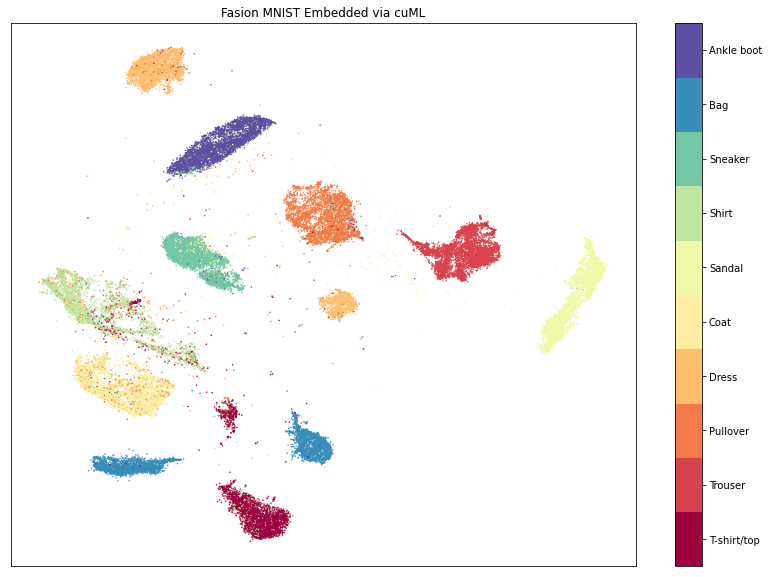

In [151]:
embedding = dist_pred

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(embedding[:,1], embedding[:,0], s=0.3, c=y, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
if classes is not None:
    cbar.set_ticklabels(classes)
plt.title("%s Embedded via %s" % ("Fasion MNIST", "cuML"));

In [152]:
local_pred = local_model.transform(X)

In [153]:
trustworthiness(local_pred, X, n_neighbors=10)

/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 
  """Entry point for launching an IPython kernel.


0.9361048227350479

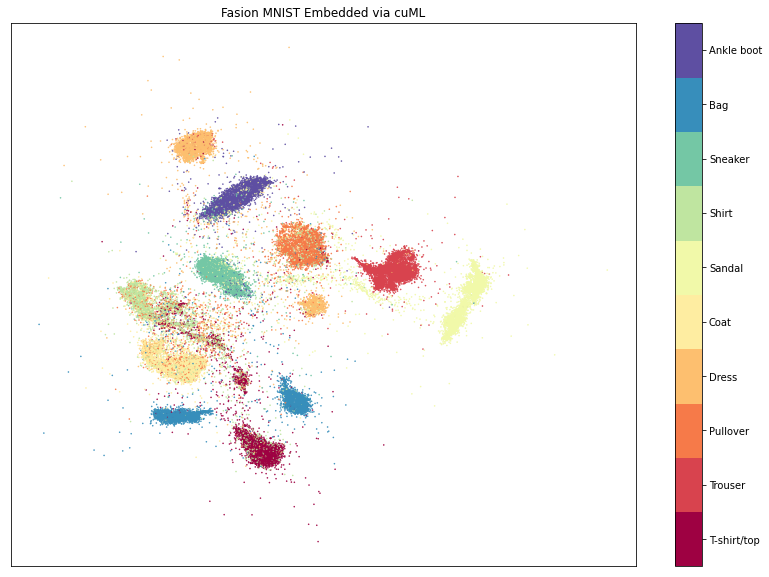

In [154]:
embedding = local_pred

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(embedding[:,1], embedding[:,0], s=0.3, c=y, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
if classes is not None:
    cbar.set_ticklabels(classes)
plt.title("%s Embedded via %s" % ("Fasion MNIST", "cuML"));

In [ ]:
Fashion  (n_neighbors=50, min_dist=0.01): {'umapcuml': {'unsupervised': {'time': 1.691455602645874,
   'trust': 0.9756608852027691},
  'supervised': {'time': 2.351792097091675, 'trust': 0.9720590243890228},
  'xform': {'time': 2.395686626434326, 'trust': 0.9721990809657708}},
 'umapgpumap': {'unsupervised': {'time': 8.455759525299072,
   'trust': 0.966088003226282},
  'supervised': {'time': 11.22615909576416, 'trust': 0.946432295621991},
  'xform': {'time': 12.111764907836914, 'trust': 0.9451657405457423}},
 'umaplearn': {'unsupervised': {'time': 129.88665342330933,
   'trust': 0.9785036958283618},
  'supervised': {'time': 167.90911030769348, 'trust': 0.9759003309442159},
  'xform': {'time': 169.7406485080719, 'trust': 0.9752538816065772}}}

Fashion default: {'umaplearn': {'unsupervised': {'time': 70.07299304008484,
   'trust': 0.977692662316851},
  'supervised': {'time': 89.2359881401062, 'trust': 0.9768497406042687},
  'xform': {'time': 88.11038374900818, 'trust': 0.9766910591282214}},
 'umapcuml': {'unsupervised': {'time': 1.0602912902832031,
   'trust': 0.9756579316886288},
  'supervised': {'time': 1.2528660297393799, 'trust': 0.9753220467475495},
  'xform': {'time': 1.2345595359802246, 'trust': 0.9758428593923967}},
 'umapgpumap': {'unsupervised': {'time': 8.032711505889893,
   'trust': 0.9745967157039829},
  'supervised': {'time': 11.146373987197876, 'trust': 0.9578011941244143},
  'xform': {'time': 11.902178287506104, 'trust': 0.9567292975640662}}}

Fashion (n_neighbors:5, min_dist:0.01):
{'umaplearn': {'unsupervised': {'time': 46.197495460510254,
   'trust': 0.9844126808574477},
  'supervised': {'time': 50.494110107421875, 'trust': 0.9824418088522914},
  'xform': {'time': 49.34948992729187, 'trust': 0.9834457064275237}},
 'umapcuml': {'unsupervised': {'time': 0.8439412117004395,
   'trust': 0.9790508081077477},
  'supervised': {'time': 0.9139008522033691, 'trust': 0.9791517042272303},
  'xform': {'time': 0.9139800071716309, 'trust': 0.9787407767702361}},
 'umapgpumap': {'unsupervised': {'time': 8.223836183547974,
   'trust': 0.9789080655198471},
  'supervised': {'time': 11.491980791091919, 'trust': 0.9687381260279149},
  'xform': {'time': 12.231558799743652, 'trust': 0.9701084106214162}}}

Cifar-100 default: {'umaplearn': {'unsupervised': {'time': 114.65315198898315,
   'trust': 0.846886604198276},
  'supervised': {'time': 107.9702365398407, 'trust': 0.843361072892757},
  'xform': {'time': 106.28120398521423, 'trust': 0.8480973411474398}},
 'umapcuml': {'unsupervised': {'time': 2.404963731765747,
   'trust': 0.8350443612829362},
  'supervised': {'time': 2.6520259380340576, 'trust': 0.8384520656992588},
  'xform': {'time': 2.6225061416625977, 'trust': 0.8362343168029226}},
 'umapgpumap': {'unsupervised': {'time': 7.503326892852783,
   'trust': 0.8334274633424295},
  'supervised': {'time': 10.095724105834961, 'trust': 0.8307568528676733},
  'xform': {'time': 10.978502750396729, 'trust': 0.8307642823082182}}}

Cifar-100 (n_neighbors:5): {'umaplearn': {'unsupervised': {'time': 67.82002830505371,
   'trust': 0.8581266525536738},
  'supervised': {'time': 76.06079483032227, 'trust': 0.8611072494110326},
  'xform': {'time': 82.10008549690247, 'trust': 0.8609734462928391}},
 'umapcuml': {'unsupervised': {'time': 2.640801429748535,
   'trust': 0.8384547320198249},
  'supervised': {'time': 2.2339065074920654, 'trust': 0.8409368907521003},
  'xform': {'time': 2.2544515132904053, 'trust': 0.8369009832977731}},
 'umapgpumap': {'unsupervised': {'time': 9.76174783706665,
   'trust': 0.8398398837067165}}}

Cifar-100 (n_neighbors:50): {'umaplearn': {'unsupervised': {'time': 247.36368441581726,
   'trust': 0.8406418578934047},
  'supervised': {'time': 216.87787103652954, 'trust': 0.8390893277040276},
  'xform': {'time': 218.298357963562, 'trust': 0.838630387632215}},
 'umapcuml': {'unsupervised': {'time': 3.350353240966797,
   'trust': 0.832504358512239},
  'supervised': {'time': 3.9427123069763184, 'trust': 0.8328878041702475},
  'xform': {'time': 3.9466609954833984, 'trust': 0.8346442010196163}},
 'umapgpumap': {'unsupervised': {'time': 11.36575698852539,
   'trust': 0.8350418430691954}}}


In [1]:
from sklearn import Pipeline

ImportError: cannot import name 'Pipeline' from 'sklearn' (/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/sklearn/__init__.py)

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.pipeline import Pipeline, FeatureUnion

In [3]:
from cuml import PCA, UMAP

/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cudf/utils/cudautils.py:7: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.numpy_support', please update to use 'numba.np.numpy_support' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba import cuda, numpy_support
/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cudf/core/column/categorical.py:12: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.numpy_support', please update to use 'numba.np.numpy_support' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from cudf._lib.transform import bools_to_mask
/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cudf/utils/applyutils.py:7: NumbaDeprecationWarning: An import was requested from a module that h

In [5]:
pipeline = Pipeline([('pp', PCA()), ('viz', UMAP())])

In [6]:
from cuml.datasets import make_blobs

In [9]:
x,_ = make_blobs()

In [10]:
pipeline.fit(x)

/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('pp',
                 PCA(copy=True, handle=<cuml.common.handle.Handle object at 0x7f1df762d170>, iterated_power=15, n_components=1, random_state=None, svd_solver='auto', tol=1e-07, verbose=False, whiten=False, output_type='numba')),
                ('viz',
                 UMAP(n_neighbors=15, n_components=2, n_epochs=0, learning_rate=1.0, min_dist=0.1, spread=1.0, set_op_mix_ratio=1.0, l..._rate=5, transform_queue_size=4.0, init='spectral', verbose=False, a=1.576943460405378, b=0.8950608781227859, target_n_neighbors=-1, target_weights=0.5, target_metric='categorical', handle=<cuml.common.handle.Handle object at 0x7f1ce5c72d90>, hash_input=False, random_state=4258316317235410272, optim_batch_size=0, callback=None, output_type='numba'))],
         verbose=False)